In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np



In [2]:
from model import Net
from util import Cifar10Dataset, args, train_transforms, test_transforms

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install torchsummary

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14           [-1, 32,

In [6]:
trainset = Cifar10Dataset(root='./data', train=True, download=True, transform=train_transforms)
testset = Cifar10Dataset(root='./data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=args().batch_size,
                                          shuffle=True, **args().kwargs)

test_loader = torch.utils.data.DataLoader(testset, batch_size=args().batch_size,
                                          shuffle=True, **args().kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.90)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Epoch 1


Loss=1.74130117893219 Batch_id=390 Accuracy=28.16: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 1.6295, Accuracy: 4029/10000 (40.29%)

Epoch 2


Loss=1.3856773376464844 Batch_id=390 Accuracy=38.74: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]



Test set: Average loss: 1.5085, Accuracy: 4561/10000 (45.61%)

Epoch 3


Loss=1.296478509902954 Batch_id=390 Accuracy=44.56: 100%|██████████| 391/391 [00:22<00:00, 17.77it/s]



Test set: Average loss: 1.4279, Accuracy: 4915/10000 (49.15%)

Epoch 4


Loss=1.2678978443145752 Batch_id=390 Accuracy=48.21: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 1.1787, Accuracy: 5807/10000 (58.07%)

Epoch 5


Loss=1.2743709087371826 Batch_id=390 Accuracy=54.90: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s]



Test set: Average loss: 1.0829, Accuracy: 6292/10000 (62.92%)

Epoch 6


Loss=1.3151721954345703 Batch_id=390 Accuracy=56.05: 100%|██████████| 391/391 [00:22<00:00, 17.70it/s]



Test set: Average loss: 1.0441, Accuracy: 6403/10000 (64.03%)

Epoch 7


Loss=1.277121663093567 Batch_id=390 Accuracy=56.98: 100%|██████████| 391/391 [00:21<00:00, 18.14it/s]



Test set: Average loss: 1.0266, Accuracy: 6473/10000 (64.73%)

Epoch 8


Loss=1.3647741079330444 Batch_id=390 Accuracy=57.45: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s]



Test set: Average loss: 0.9936, Accuracy: 6572/10000 (65.72%)

Epoch 9


Loss=1.002092719078064 Batch_id=390 Accuracy=58.63: 100%|██████████| 391/391 [00:21<00:00, 18.21it/s]



Test set: Average loss: 0.9923, Accuracy: 6597/10000 (65.97%)

Epoch 10


Loss=1.0797250270843506 Batch_id=390 Accuracy=58.61: 100%|██████████| 391/391 [00:21<00:00, 18.33it/s]



Test set: Average loss: 0.9852, Accuracy: 6617/10000 (66.17%)

Epoch 11


Loss=1.337937593460083 Batch_id=390 Accuracy=58.88: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s]



Test set: Average loss: 0.9773, Accuracy: 6632/10000 (66.32%)

Epoch 12


Loss=1.0219091176986694 Batch_id=390 Accuracy=58.94: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]



Test set: Average loss: 0.9865, Accuracy: 6589/10000 (65.89%)

Epoch 13


Loss=1.4873359203338623 Batch_id=390 Accuracy=59.01: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s]



Test set: Average loss: 0.9771, Accuracy: 6632/10000 (66.32%)

Epoch 14


Loss=1.1328552961349487 Batch_id=390 Accuracy=59.12: 100%|██████████| 391/391 [00:22<00:00, 17.55it/s]



Test set: Average loss: 0.9788, Accuracy: 6633/10000 (66.33%)

Epoch 15


Loss=1.1250743865966797 Batch_id=390 Accuracy=59.26: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s]



Test set: Average loss: 0.9799, Accuracy: 6651/10000 (66.51%)

Epoch 16


Loss=1.1230074167251587 Batch_id=390 Accuracy=59.38: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s]



Test set: Average loss: 0.9821, Accuracy: 6633/10000 (66.33%)

Epoch 17


Loss=1.2652568817138672 Batch_id=390 Accuracy=58.93: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]



Test set: Average loss: 0.9806, Accuracy: 6618/10000 (66.18%)

Epoch 18


Loss=1.0994515419006348 Batch_id=390 Accuracy=59.12: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s]



Test set: Average loss: 0.9780, Accuracy: 6628/10000 (66.28%)

Epoch 19


Loss=1.2669572830200195 Batch_id=390 Accuracy=59.18: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.9801, Accuracy: 6622/10000 (66.22%)

Epoch 20


Loss=1.1005998849868774 Batch_id=390 Accuracy=59.29: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s]



Test set: Average loss: 0.9791, Accuracy: 6624/10000 (66.24%)



Text(0.5, 1.0, 'Test Accuracy')

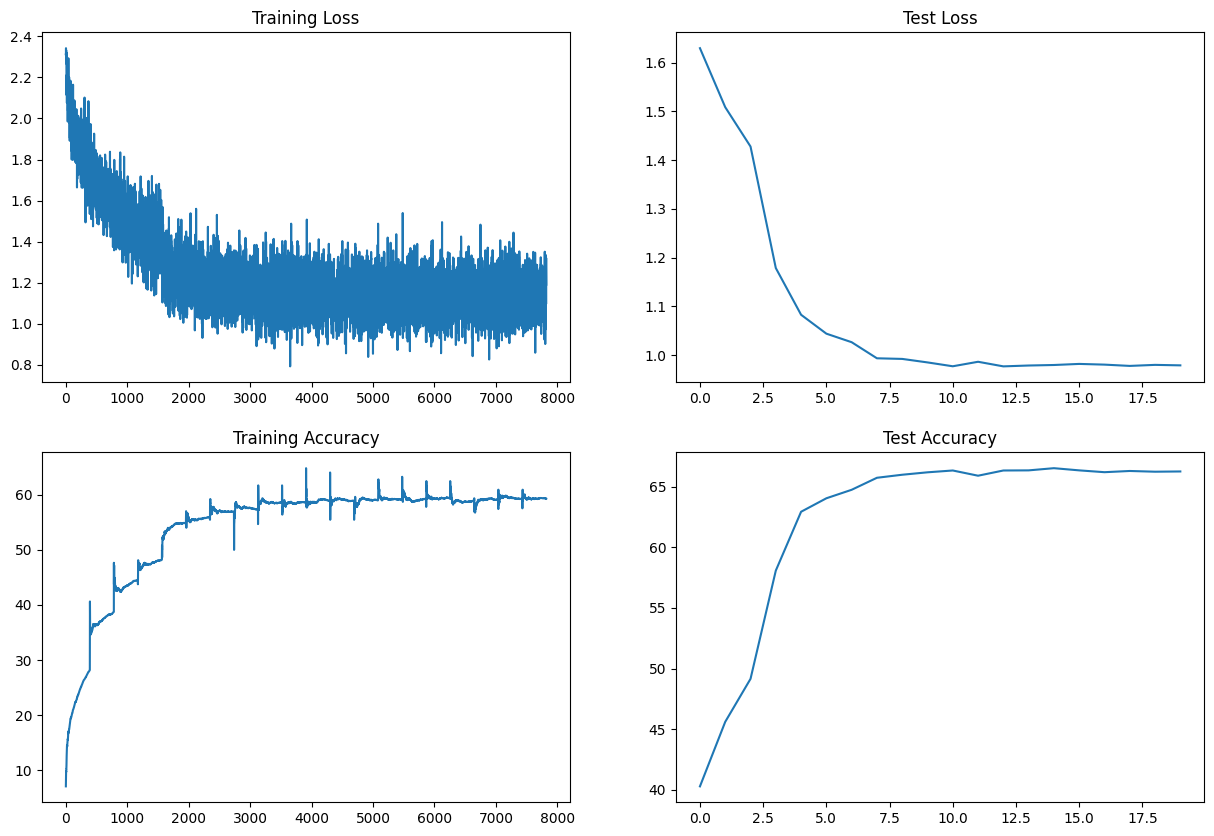

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.tensor(train_losses).cpu().detach().numpy())
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")